In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import model as md
import time
import pickle

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'SiouxFalls_net.tntp'
trips_name = 'SiouxFalls_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [4]:
graph_data['graph_table']['Init node'].as_matrix()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,
        7,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11,
       12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22,
       22, 22, 23, 23, 23, 24, 24, 24], dtype=int8)

In [5]:
def costs_func(df, i, j, column):
    rows = df.loc[df['Init node'] == i]
    columns = rows.loc[df['Term node'] == j]
    c = columns[column]
    print(rows)
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return np.nan

def create_T(df):
    T = np.full((n, n), np.nan, dtype=np.double)
    
    i_matrix = df['Init node'].as_matrix()
    j_matrix = df['Term node'].as_matrix()
    
    for i in i_matrix:
        for j in j_matrix:
            data = df.loc[(df['Init node'] == i) & 
                             (df['Term node'] == j)]
            if not data.empty:
                T[i-1][j-1] = data['Free Flow Time'].as_matrix()[0]
    return T

def create_cor_matr(dictnr):
    correspondence_matrix = np.full((n, n), np.nan, dtype=np.double)
    i = 1
    
    for key in dictnr[i].keys():
        for k, v in zip(dictnr[key].keys(),
                    dictnr[key].values()):
            correspondence_matrix[key - 1][k - 1] = v
        i += 1
        
    return correspondence_matrix

In [6]:
correspondence_matrix = create_cor_matr(graph_correspondences)

In [7]:
df = graph_data['graph_table']
df[df['Init node'] == 2].head()

,Init node,Term node,Capacity,Free Flow Time
2,2,1,25900.201172,6.0
3,2,6,4958.181152,5.0


In [8]:
print(df['Init node'].unique())
print(np.sort(df['Term node'].unique()))
print(df['Free Flow Time'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 6.  4.  5.  2.  3. 10.  8.]


In [9]:
df.head()

,Init node,Term node,Capacity,Free Flow Time
0,1,2,25900.201172,6.0
1,1,3,23403.472656,4.0
2,2,1,25900.201172,6.0
3,2,6,4958.181152,5.0
4,3,1,23403.472656,4.0


In [163]:
T = create_T(df)
np.savetxt('T.csv', T, delimiter=',')

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по 0.01 часа ('The units of free flow travel times are 0.01 hours, but they are often viewed as if they were minutes'). Переведём их в минуты

In [110]:
def distributor_L_W(array):
    max_value = np.max(array)
    max_value_index = np.where(array == np.max(array))
    
    unique, counts = np.unique(array, return_counts=True)
    array_dict = dict(zip(unique, counts))
    print(array_dict)
    zero_num = array_dict[0]
    
    array[max_value_index] = max_value - zero_num
    for index in np.where(array == 0)[0]:
        array[index] = 1.0
    
    return array

In [111]:
L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = L / np.nansum(L)
W = W / np.nansum(W)
print('people_num: ', people_num)

people_num:  360600.0


In [112]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):    
    lambda_L = np.zeros((n, ), dtype=np.double)
    lambda_W = np.zeros((n, ), dtype=np.double)
    
    if k % 2 == 0:
        lambda_W = lambda_W_prev
        lambda_L = np.log(np.nansum(
            (np.exp(-lambda_W_prev - 1 - cost_matrix)).T 
            / L, axis = 0
            ))
    else:
        lambda_L = lambda_L_prev
        lambda_W = np.log(np.nansum(
            (np.exp(-lambda_L - 1 - cost_matrix.T)).T
            / W, axis=0
            ))
        
    return lambda_W, lambda_L

def iterate(cost_matrix, L, W, num_iter, eps):
    
    lambda_L = np.zeros((n, ), dtype=np.double)
    lambda_W = np.zeros((n, ), dtype=np.double)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, 
                                               lambda_Wn - lambda_W)))
        
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
        
        if delta < eps:
            print('ok')
            break
    
    r = error_d_i_j(lambda_Ln, lambda_Wn, cost_matrix)
    return r

def error_d_i_j(lambda_L, lambda_W, cost_matrix):
    er = np.exp( -1 - cost_matrix - (np.reshape(lambda_L, (n, 1)) + lambda_W))
    return er * people_num

In [160]:
num_iter = 1500
alpha, beta = 1.0, 1.0
beta_range  = np.arange(0.01, 3.0, 0.1)
alpha_range = np.arange(0.01, 3.0, 0.1)

res_array = np.full((len(alpha_range), len(beta_range)), np.nan)

i, j = 0, 0
f = open("KEV_data_2.txt", "w")

for alpha in alpha_range:
    for beta in beta_range:
        cost_matrix = (T ** beta) * alpha
        rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-2))    
        res = np.linalg.norm(np.nan_to_num(rec, nan = 0.0) 
                                            - np.nan_to_num(correspondence_matrix, 
                                                            nan=0.0))
        f.write(str(alpha) + ' ' + str(beta) + ' ' + str(res) + '\n')
        res_array[i][j] = res
        j += 1
        
    i += 1
    j = 0
    
f.close()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add


In [161]:
np.min(res_array), np.where(res_array == np.min(res_array))

(22406.69542792957,
 (array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,

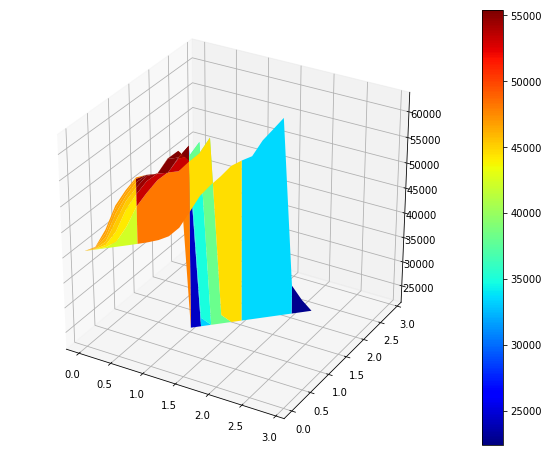

In [162]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(10, 8)) 
ax = fig.add_subplot(111, projection = '3d')
surf = ax.plot_surface(alpha_range, beta_range, res_array, rstride = 5, cstride = 5, \
       cmap = matplotlib.cm.jet)
fig.colorbar(surf)

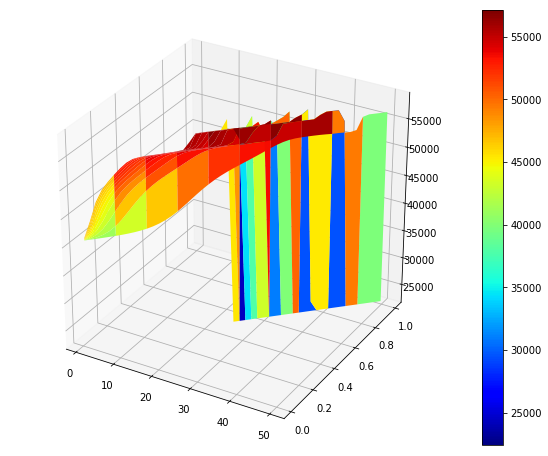

In [120]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection = '3d')
surf = ax.plot_surface(alpha_range, beta_range, res_array, rstride = 5, cstride = 5, \
       cmap = matplotlib.cm.jet)
fig.colorbar(surf)

##### Best recovery corr matrix  

In [ ]:
rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-4))

##### Multi-stage